# LSI31003 Machine Learning in Molecular Biology Assignment 3

# Problem description:
In this exercise, you will create a binary classifier, that classifies short peptide (=amino-acid) sequences into Antimicribial peptides (AMP) and non-Antimicrobial peptides (nonAMP). The sequences are provided as 2 sets of .fasta -formatted files, with each having several thousand short peptides from their respective classes.

Our first task is to to extract the peptide sequences and somehow represent them numerically, so that we can apply machine learning methods for our classifier. There are several classical and modern methods to do this. In this case, we use ESM-2 model, a pretrained large deeplearning-based neural network developed by facebook research team (https://github.com/facebookresearch/esm). The model is trained on large database of **UniRef**, and it is based on a BERT-like model architecture, which is a stack of transformer-encoders. Models like this aim to model the language of each token (word, amino-acid, microbe etc. in a sequence) based on their surrounding tokens to derive an **embedding**, a vector that captures the overall meaning of each token based on the overall sequence. Notably, as we are using a pretrained model, no additional training is needed by us for using the model: we are just passing the data through the model iin inference mode in a feed forward fashion, and recovering the embeddings. For the interested, you can learn more about models like these by searching with keywords (Transformer Encoder, BERT, ESM 2 etc.). Transformers are the main technology that have revolutionalized the recent surge in LLM based AI. Here are a few papers for the interested, if you wish to learn more:  

"Attention is all you need" (Vaswani *et al.*): https://arxiv.org/pdf/1706.03762 (first paper introducing transformers)  
"Evolutionary-scale prediction of atomic-level protein structure with a language model" (Lin *et al*): https://doi.org/10.1126/science.ade2574  
(paper introducing ESM-2 model used in this exercise)

Let's see in practice how the Esm-2 model is used to derive the peptide embeddings. We have done this step in advance for you, as ESM-2 is such a large model (the version of ESM we are using has 33 transformer layers and 650M parameters!) that it takes a lot of time to run. 

## Problem 0 (Introduction)

In this section, we go through the  preprocessing steps for getting the input data for this exercise.   
**There is no need to run any code in this section, and the needed python libraries aren't installed in the csc notebooks by default!**.   
Exercises start at Problem 1!  

Still, make sure that you understand how the code in this part works and what **token embeddings** essentially are.

In [1]:
# required packages (not in CSC naturally)
from Bio import SeqIO # Biopython (for parsing fasta files). install: pip install biopython
import esm # (Pretrained transformer model for embedding protein sequences). install: pip install fair-esm
import torch

In [2]:
# loading amp peptides from fasta file
amp = list(SeqIO.parse("data/train_AMP_3268.fasta", "fasta"))
amp = [(s.id, str(s.seq)) for s in amp]
print(f"Number of AMP sequences: {len(amp)}")
print("First records:")
amp[:5]

Number of AMP sequences: 3268
First records:


[('AMP_1', 'AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC'),
 ('AMP_2', 'AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAMDLELQKIAEKFSQR'),
 ('AMP_3',
  'AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTNGVGNTHNVDKTKILTIDEVATDLRRNIKEAENCINTYFNGEKMNQGQYDAMVSLAFNVGCGNIKTYYSKTQGKRVATTIYRAAQAENWILMCNRIEDFNKSGGRVLKGLQNRRAKEKALCLGE'),
 ('AMP_4', 'AAFRGCWTKNYSPKPCL'),
 ('AMP_5', 'AAGMGFFGAR')]

In [3]:
# loading nonAmp peptides from fasta file
nonAmp = list(SeqIO.parse("data/train_nonAMP_9777.fasta", "fasta"))
nonAmp = [(s.id, str(s.seq)) for s in nonAmp]
print(f"Number of nonAMP sequences: {len(nonAmp)}")
print("First records:")
nonAmp[:5]

Number of nonAMP sequences: 9777
First records:


[('nonamp_1',
  'MNNNTTAPTYTLRGLQLIGWRDMQHALDYLFADGHLKQGTLVAINAEKMLTIEDNAEVRELINAAEFKYADGISVVRSVRKKYPQAQVSRVAGADLWEELMARAGKEGTPVFLVGGKPEVLAQTEAKLRNQWNVNIVGSQDGYFKPEQRQALFERIHASGAQIVTVAMGSPKQEIFMRDCRLVHPDALYMGVGGTYDVFTGHVKRAPKIWQTLGLEWLYRLLSQPSRIKRQLRLLRYLRWHYTGNL'),
 ('nonamp_2',
  'MKSLLPLAILAALAVAALCYESHESMESYEVSPFTTRRNANTFISPQQRWHAKAQERVRELNKPAQEINREACDDYKLCERYALIYGYNAAYNRYFRQRRGAK'),
 ('nonamp_3',
  'MASVTDGKTGIKDASDQNFDYMFKLLIIGNSSVGKTSFLFRYADDTFTPAFVSTVGIDFKVKTVYRHEKRVKLQIWDTAGQERYRTITTAYYRGAMGFILMYDITNEESFNAVQDWATQIKTYSWDNAQVILVGNKCDMEEERVVPTEKGRLLAEQLGFDFFEASAKENISVRQAFERLVDAICDKMSDSMDTDPSVLGASKTTRLSDTPPLLQQNCSC'),
 ('nonamp_4',
  'MASFQDRAQHTIAQLDKELSKYPVLNNLERQTSVPKVYVILGLVGIYTFLVFFNIAGEFLVNFAGFLIPGYYSLNALFTSGKADDTQWLTYWVVYALLTVVESAINAAYWFPFYYIFKFVLILWMSLPQTNGAQVVFHSFLQPVLGRFFTSGSTSANLRAQADAASKSQ'),
 ('nonamp_5',
  'MRHRSGLRKLNRTSSHRQAMFRNMANSLLRHEVIKTTLPKAKELRRVVEPLITLGKKPSLSNRRLAFNRMRDREMVVKLFDVLGPRFAERNGGYLRILKFGFRDGDNAPLALIELLDRPDEGEEGANVSEAAAA')]

Next, we have to decide how to represent the sequences, currently as strings/ letters of amino acids, in some sort of way to represent them numerically so that clustering algorithms can use them. There are many ways to do that, such as one hot encoded sparse matrices etc. Here we use a modern application of neutral network based thransformer model know as ESM-2 to learn a fixed length numerical embedding that produces a fixed length vector representations (# embeddings) for the sequences.

Esm-2 model: 
github: (https://github.com/facebookresearch/esm)  
Publication: (https://doi.org/10.1126/science.ade2574)



In [4]:
# Load ESM-2 model
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
esm_model.eval()  # disables dropout for deterministic results

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [5]:
def create_esm_embeddings(records, batch_size = 10):
    "Given a list of (name, sequence) tuples, return 1280 dimensional embeddings for the sequences using esm 2 (in minibatches)"
    
    print(f"Starting: 0 / {len(records)} processed")
    sequence_representations = []
    for idx in range(0, len(records), batch_size):
        sub_r = records[idx: idx+batch_size]
        batch_labels, batch_strs, batch_tokens = batch_converter(sub_r)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    
    # Extract per-residue representations (on CPU)
        #print("starting embedding")
        with torch.no_grad():
            results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
        # return token (amino acid) level representations
        token_representations = results["representations"][33]
        #print("Ended embedding")
    
        # summarise sequence embeddings by taking an average representation of indivisual amino acis representations
        #sequence_representations = []
        for i, tokens_len in enumerate(batch_lens):
            sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).numpy()) # 1:st token = beginning of sequence
        if idx % 100 == 0:
            print(f"{idx + batch_size}/{len(records)} processed")
    return np.array(sequence_representations)
    

In [ ]:
# Running esm with laptop without GPU, it takes about 2h to get all the embeddings for both AMP and nonAMP sequences
# (approx. 1min/ 100 sequences)

In [ ]:
amp_embeddings = create_esm_embeddings(amp)

In [ ]:
amp_ids = [i[0] for i in amp]
nonAmp_ids = [i[0] for i in nonAmp]

In [ ]:
amp_embeddings_db = pd.DataFrame(amp_embeddings, index = amp_ids)
amp_embeddings_db
#amp_embeddings_db.to_csv("./data/amp_embeddings.csv", index = True, header = False)
pd.read_csv("./data/amp_embeddings.csv", index_col=0, header = None)

In [ ]:
nonAmp_embeddings = create_esm_embeddings(nonAmp)

In [ ]:
nonAmp_embeddings_db = pd.DataFrame(nonAmp_embeddings, index = nonAmp_ids)
nonAmp_embeddings_db
nonAmp_embeddings_db.to_csv("./data/nonAmp_embeddings.csv", index = True, header = False)

## Problem 1: Start here

To begin with, let's start with data exploration to understand the embedding space of the peptides a little better. Let's start by loading the embeddings that are calculated in introduction section, as well as some useful python packages:

In [2]:
# install umap package to CSC
import sys
!{sys.executable} -m pip install umap-learn --quiet


[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
import umap

2026-01-30 07:47:32.468142: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 07:47:32.469939: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 07:47:32.472906: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 07:47:32.482262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-30 07:47:32.500416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [4]:
# loading the embeddings of peptide samples calculated previously
amp_embeddings_db = pd.read_csv("./data/amp_embeddings.csv", index_col=0, header = None)
nonAmp_embeddings_db = pd.read_csv("./data/nonAmp_embeddings.csv", index_col=0, header = None)

In [5]:
full_joined = pd.concat([amp_embeddings_db, nonAmp_embeddings_db])
full_joined

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,,,,,,,,,,,,,,,,,,,,,
AMP_1,0.014342,0.004682,-0.013482,0.061985,0.023061,0.037844,0.053571,-0.108715,-0.011962,0.067631,...,0.040662,-0.100790,-0.057957,0.078755,-0.018841,-0.029696,0.082424,-0.118281,0.052962,0.021611
AMP_2,0.029574,-0.032031,-0.029976,0.005425,0.107714,-0.038460,0.022985,0.047300,0.056685,-0.077634,...,0.065646,-0.066865,-0.056404,0.003886,0.028032,-0.032754,0.032590,-0.018044,-0.056028,0.059788
AMP_3,0.032092,-0.066976,0.030874,0.010585,-0.080048,0.003445,-0.045020,-0.171661,-0.012036,0.011709,...,0.015204,-0.106497,-0.041337,0.036535,0.062452,0.059632,0.083556,-0.063772,-0.019125,0.123921
AMP_4,0.010460,0.072713,0.065217,0.148420,-0.114155,0.064994,-0.062795,0.226721,0.075170,0.052494,...,-0.030024,-0.042414,-0.085001,0.139244,0.053433,0.172049,-0.019894,-0.009809,-0.095184,-0.055168
AMP_5,-0.018827,0.068184,0.102889,0.129557,0.002758,-0.063008,-0.073378,0.132309,0.219381,-0.136066,...,0.001020,-0.065990,0.009460,0.095798,0.025009,0.071803,-0.071729,0.132353,-0.093302,-0.004248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nonamp_9027,0.101901,0.095176,-0.040445,0.110888,-0.059130,-0.079824,0.092475,-0.066384,0.031427,0.094908,...,0.030338,-0.131573,-0.109306,0.057318,0.011845,0.119447,0.011759,-0.086561,-0.074155,0.035567
nonamp_9028,0.061399,-0.046151,-0.018128,0.069272,-0.134613,-0.115523,0.034143,-0.155009,0.048599,-0.008081,...,0.099935,-0.065305,-0.101227,-0.024423,-0.055469,-0.037229,0.117695,-0.220990,0.026511,0.013711
nonamp_9029,0.058862,-0.011632,-0.002979,0.100874,-0.087658,-0.043787,0.078285,-0.173151,-0.047375,0.034915,...,0.086672,-0.103319,-0.098629,-0.024321,-0.069187,-0.070853,0.138830,-0.071135,-0.074210,-0.013261


### Problem 1a:
Perform PCA decomposition of the peptide embeddings. Make a scatterplot of the first 2 pincipal components. Color the points based on their class (AMP or nonAMP). Extract the proportions of the variance explained by the 2 components (%) from tthe fitted pca model, and add them to the axis labels. 

After having done this, describe your initial assumptions on whether the embeddings seem to contain relevant information for building a classifier that separates AMP's from nonAMP'?

*hint: PCA.fit() vs PCA.fit_transform()*

In [6]:
full_joined = full_joined.dropna(axis=0)
full_joined

,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,,,,,,,,,,,,,,,,,,,,,
AMP_1,0.014342,0.004682,-0.013482,0.061985,0.023061,0.037844,0.053571,-0.108715,-0.011962,0.067631,...,0.040662,-0.100790,-0.057957,0.078755,-0.018841,-0.029696,0.082424,-0.118281,0.052962,0.021611
AMP_2,0.029574,-0.032031,-0.029976,0.005425,0.107714,-0.038460,0.022985,0.047300,0.056685,-0.077634,...,0.065646,-0.066865,-0.056404,0.003886,0.028032,-0.032754,0.032590,-0.018044,-0.056028,0.059788
AMP_3,0.032092,-0.066976,0.030874,0.010585,-0.080048,0.003445,-0.045020,-0.171661,-0.012036,0.011709,...,0.015204,-0.106497,-0.041337,0.036535,0.062452,0.059632,0.083556,-0.063772,-0.019125,0.123921
AMP_4,0.010460,0.072713,0.065217,0.148420,-0.114155,0.064994,-0.062795,0.226721,0.075170,0.052494,...,-0.030024,-0.042414,-0.085001,0.139244,0.053433,0.172049,-0.019894,-0.009809,-0.095184,-0.055168
AMP_5,-0.018827,0.068184,0.102889,0.129557,0.002758,-0.063008,-0.073378,0.132309,0.219381,-0.136066,...,0.001020,-0.065990,0.009460,0.095798,0.025009,0.071803,-0.071729,0.132353,-0.093302,-0.004248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nonamp_9026,-0.005398,-0.157089,-0.032047,0.015016,-0.146367,-0.029262,0.031217,-0.087497,-0.104501,0.016934,...,-0.006407,-0.139710,-0.025487,0.042407,-0.028472,0.032336,0.128862,-0.206212,0.018199,0.000223
nonamp_9027,0.101901,0.095176,-0.040445,0.110888,-0.059130,-0.079824,0.092475,-0.066384,0.031427,0.094908,...,0.030338,-0.131573,-0.109306,0.057318,0.011845,0.119447,0.011759,-0.086561,-0.074155,0.035567
nonamp_9028,0.061399,-0.046151,-0.018128,0.069272,-0.134613,-0.115523,0.034143,-0.155009,0.048599,-0.008081,...,0.099935,-0.065305,-0.101227,-0.024423,-0.055469,-0.037229,0.117695,-0.220990,0.026511,0.013711


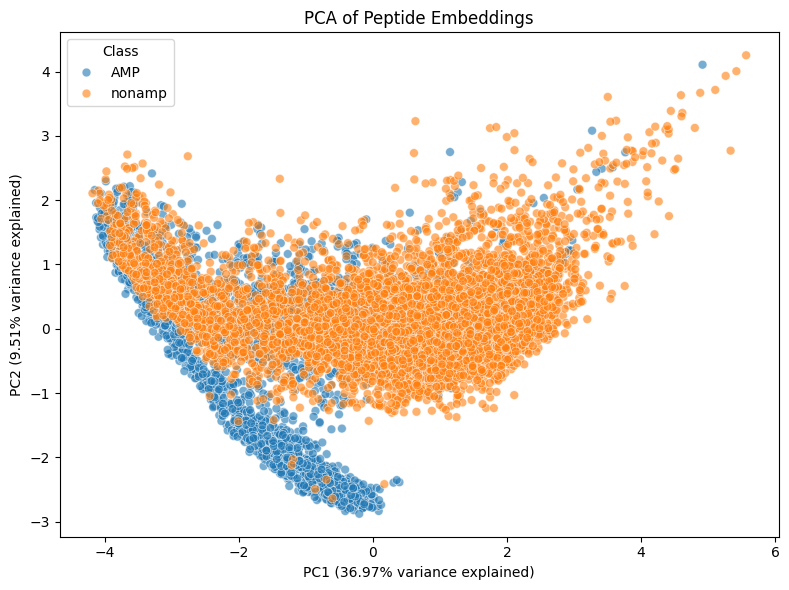

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_full = pca.fit_transform(full_joined)
explained_var = pca.explained_variance_ratio_ * 100

pc1_var = explained_var[0]
pc2_var = explained_var[1]
labels_full = full_joined.index.str.split("_").str[0]

pca_df = pd.DataFrame({
    "PC1": pca_full[:, 0],
    "PC2": pca_full[:, 1],
    "Class": labels_full
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Class",
    alpha=0.6,
    s=40
)

plt.xlabel(f"PC1 ({pc1_var:.2f}% variance explained)")
plt.ylabel(f"PC2 ({pc2_var:.2f}% variance explained)")
plt.title("PCA of Peptide Embeddings")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


There is quite high overlap between the classes, especially on the PC1, which explains most of the variance. Some of the overlap might just be noise but this amount would raise concerns if this was my dataset.

### Problem 1b:
Let's also try **Umap** as a alternative to PCA to see whether if any nonlinear local manifold structure appears when plotting the result. Again, make the scatterplot and color the samples by their class. Explore the behaviour of the `n_neighbors` parameter as well, and use one that looks best.

*hint: umap.UMAP()*

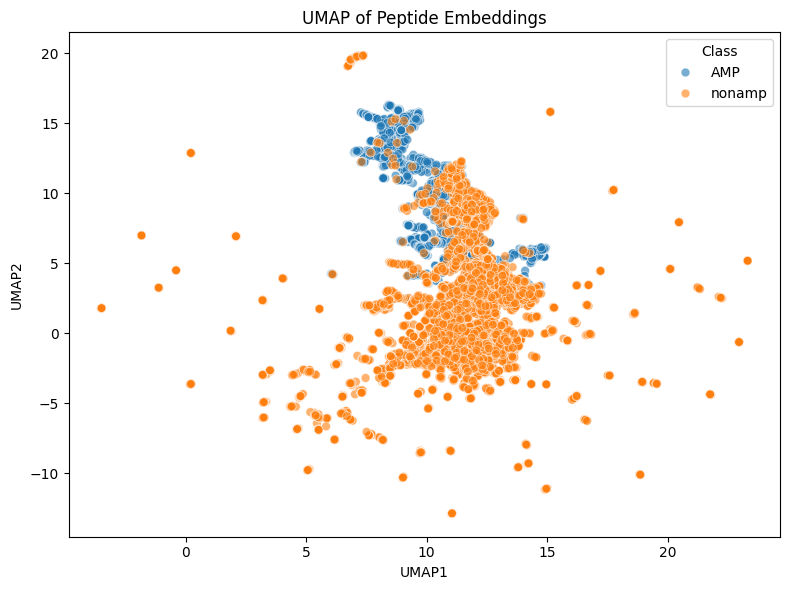

In [8]:
import umap

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=20
)

umap_full = umap_model.fit_transform(full_joined)

umap_df = pd.DataFrame({
    "UMAP1": umap_full[:, 0],
    "UMAP2": umap_full[:, 1],
    "Class": labels_full
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="Class",
    alpha=0.6,
    s=40
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of Peptide Embeddings")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

Still quite much overlap, but less than with PCA.

### Problem 1c:

From the study of language models, it has been observed that the embeddings of the imput tokens from BERT-like models (transformer encoders, such as the ESM-2 used here for deriving peptide embeddings), if treated as a vector, can capture some abstract global meaning of the inputs. In other words, embedded sequence vectors pointing in same direction are similar to each other, while orthogonal embeddings have minimal relation to each other.

To test if we can observe differences between the embeddings of AMP's and nonAMP's, let's visualize appropriate vector comparisons between the two peptide groups:

Calculate and visualize a cosine similarity matrix for 100 AMP embeddings and 100 nonAMP embeddings. Can you observe any interesting structure? Do AMP embeddings seem more similar to each other than to nonAMP embeddings?

hints: *sns.heatmap()*

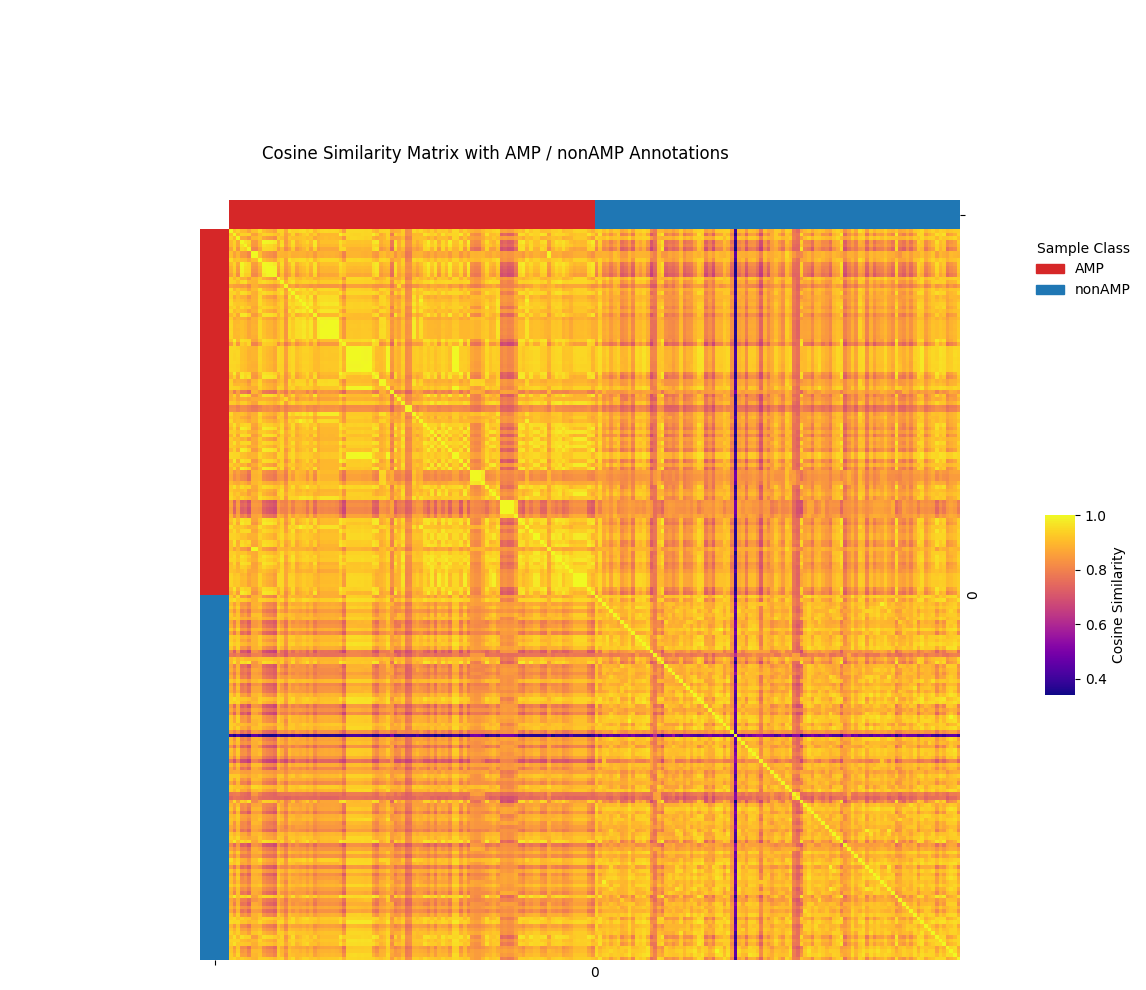

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.patches as mpatches

amp_df = full_joined[full_joined.index.str.startswith("AMP_")].iloc[:100]
nonamp_df = full_joined[full_joined.index.str.startswith("nonamp_")].iloc[:100]
subset_df = pd.concat([amp_df, nonamp_df])

cos_sim_matrix = cosine_similarity(subset_df.values)

cos_sim_df = pd.DataFrame(
    cos_sim_matrix,
    index=subset_df.index,
    columns=subset_df.index
)

groups = pd.Series(
    np.where(subset_df.index.str.startswith("AMP"), "AMP", "nonAMP"),
    index=subset_df.index
)
group_palette = {
    "AMP": "#d62728",      # red
    "nonAMP": "#1f77b4"    # blue
}

row_colors = groups.map(group_palette)
col_colors = row_colors.copy()

g = sns.clustermap(
    cos_sim_df,
    row_cluster=False,
    col_cluster=False,
    row_colors=row_colors,
    col_colors=col_colors,
    cmap="plasma",
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 10),
    cbar_kws={"label": "Cosine Similarity"},
    cbar_pos=(1.05, 0.3, 0.03, 0.18)  # (x, y, width, height)
)

# Title
g.fig.suptitle(
    "Cosine Similarity Matrix with AMP / nonAMP Annotations",
    y=0.85
)

# Legend for row/column color annotations
legend_handles = [
    mpatches.Patch(color=group_palette["AMP"], label="AMP"),
    mpatches.Patch(color=group_palette["nonAMP"], label="nonAMP")
]

g.ax_heatmap.legend(
    handles=legend_handles,
    title="Sample Class",
    loc="upper right",
    bbox_to_anchor=(1.25, 1.0),
    frameon=False
)

plt.show()


Inside the classes there seems to be smaller clusters that have more similarity. Overall the AMPs seem to be more similar amoung themselves.

## Problem 2: Make a binary classifier to separate AMP sequences from nonAMP's

### Problem 2a: 
Test at least two different machine learning classifier models for separating the peptide sequences into AMP's and nonAMP's using the sequence embeddings generated by ESM-2 transformer model. Internally compare the performance of different models with cross-validation, and report which model appears best, based on classification accuracy or other relevant metric. How well the model appears to work based on your evaluation with labeled samples (based on for example classication accuracy).

hints:
Useful documentation for classification models (supervised learning): https://scikit-learn.org/stable/supervised_learning.html  
Useful function for model comparison:
`cross_val_score`


### Ideas on what you could do

Potential Models:
- logistic regression
- lasso, Ridge, Elasticned (penalized models)
- random forest
- svm
- neural nets (MLP, CNN etc.)
- KNN
- etc.

Exploration of dimensionality reduction methods:
- Umap
- PCA

Generalizability and model selection
- K-fold CV, Leave One Out CV



#### We split the dataset into training and validation sets. Use only X_train and y_train for problem 2a.

In [10]:
# for Problem 2a, use only X_train samples and and y_train labels for supervised learning (with y_train known). Validation dataset used later
#y = ["AMP"] * amp_embeddings_db.shape[0] + ["nonAMP"] * nonAmp_embeddings_db.shape[0]
y = full_joined.index.str.startswith("AMP").astype(int)
X_train, X_val, y_train, y_val = train_test_split(
    full_joined, y, test_size=0.1, random_state=42, stratify=y
)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(
    rf,
    full_joined.values,
    y,
    cv=cv,
    scoring="accuracy" 
)

print(f"RF accuracy: {rf_scores.mean():.3f} ± {rf_scores.std():.3f}")


CNN accuracy: 0.967 ± 0.004


In [24]:
!{sys.executable} -m pip install scikeras --quiet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def build_cnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim, 1)),
        Conv1D(64, kernel_size=3, activation="relu"),
        GlobalMaxPooling1D(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    return model
    
X_cnn = full_joined.values[..., np.newaxis]

cnn_clf = KerasClassifier(
    model=build_cnn,
    model__input_dim=X_cnn.shape[1],
    loss="binary_crossentropy", 
    epochs=20,
    batch_size=32,
    verbose=0
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cnn_scores = cross_val_score(
    cnn_clf,
    X_cnn,
    y,
    cv=cv,
    scoring="accuracy"
)

print(f"CNN accuracy: {cnn_scores.mean():.3f} ± {cnn_scores.std():.3f}")


[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
CNN accuracy: 0.873 ± 0.008


Random forest has higher accuracy and lower standard deviation. We'll continue with it.

### Problem 2b: Classification of new, unknown sequences

You have now built your classifier and have an estimation of how well it can separate AMP's from nonAMP's. Let's now assume that you get a new set of peptide sequences of unknown origin (here `X_val`). Imagine that we don't have the known labels for these samples yet (although they are currently stored in variable `y_val`)

Use your best performing model to classify these sequences.

In [26]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

### Problem 2c: Final evaluation
Now use the y_val classes (that you previously pretended weren't available), and report the classification accuracy of the validation dataset. Did the model perform as well as expected based on your analysis in part 2a?

In [28]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest classification accuracy on validation set: {accuracy:.3f}")

Random Forest classification accuracy on validation set: 0.968


The results were expected. Accuracy is almost identical with the part 2a

## Problem 3:

Our data had the classes only for binary separation of AMP's and nonAMP's. However, going back to Problem 1, the embedding visualizations seemed to show some indication that there might be some finer structure within the AMP peptide class. We could therefore theoretically find out some potential subclasses of AMP's, that could behave biologically differently. Let's investigate this with clustering approaches.

### Problem 3a:
Perform K-means clustering for the AMP peptides. Try various number of cluster means and make a plot (e.g. lineplot or barplot)  that shows the model evaluation score as a function of the number of clusters. 

*hint: `sklearn.metrics.silhouette_score`  
might be useful for evaluating the optimal number of clusters with silhouette score metric.*

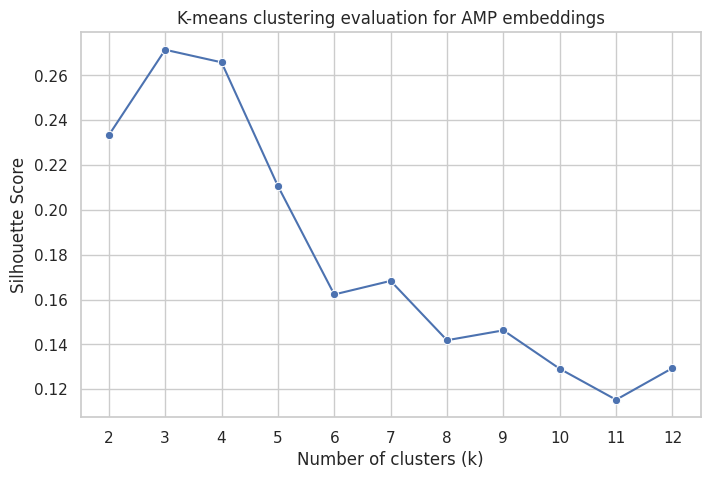

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

amp_embeddings = full_joined[full_joined.index.str.startswith("AMP")]
X_amp = amp_embeddings.values

cluster_range = range(2, 13)
sil_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_amp)
    score = silhouette_score(X_amp, labels)
    sil_scores.append(score)


sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.lineplot(x=list(cluster_range), y=sil_scores, marker="o")
plt.xticks(list(cluster_range))
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("K-means clustering evaluation for AMP embeddings")
plt.show()

### Problem 3b:
Redo the scatterplot for the AMP subgroup of peptide embeddings using Umap. Color the samples by the cluster labels of the best performing K-means model. Do you agree or disagree that the AMP's might contain subgroups based on the visual analysis?

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


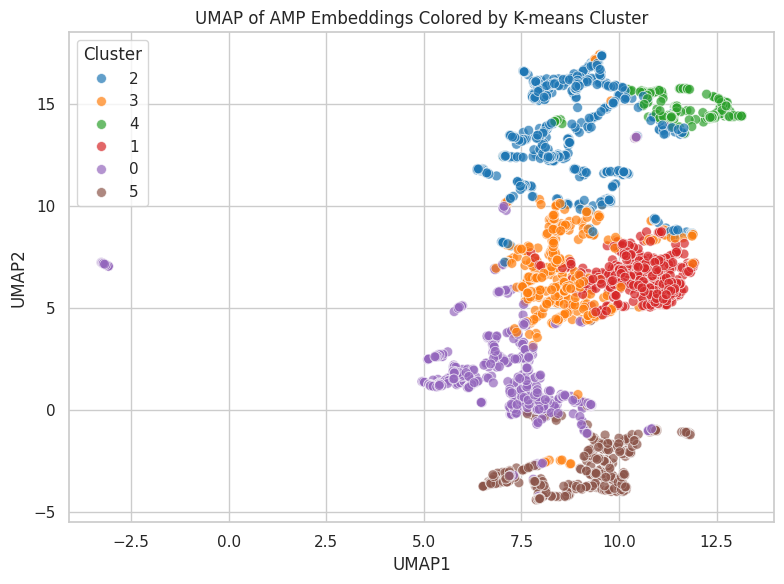

In [40]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
amp_labels = kmeans.fit_predict(X_amp)

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    random_state=41
)

umap_amp = umap_model.fit_transform(X_amp)

umap_df = pd.DataFrame({
    "UMAP1": umap_amp[:, 0],
    "UMAP2": umap_amp[:, 1],
    "Cluster": amp_labels.astype(str)  # convert to string for categorical coloring
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="Cluster",
    palette="tab10",   # nice categorical palette
    alpha=0.7,
    s=50
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of AMP Embeddings Colored by K-means Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


Clusters 0 and 5 seem to cluster well as well as 1 and 3 but it is hard to say if they should form one common or spearate clusters. These indicate that there are internal classes inside the AMP peptides.